## Ground-roll attenuation model

* [Problem description](#Problem-description)
* [Dataset](#Dataset)
* [Model architecture](#Model-architecture)
* [Training](#Training)
* [Inference](#Inference)
* [Conclusion](#Conclusion)

# Problem description

Raw field seismograms contain noises of various nature. One type of noise is assosiated with ground-roll waves propagation. The model should suppress the ground-roll noise and keep desired signal unchanged.

# Dataset

Dataset consists of a raw field seismogram and seismogram after gound roll attenuation. Dataset is split into train and validation parts:


**Train**

| Filename | About this file | Size | N ffid |  Length |
| :------ | ----: | ----: | ----: | ----: |
| 1_WZ_NA_input_51ffid.sgy | Raw field seismogram | 2.1 Gb | 51 | 6 s |
| 1_WZ_NA_output_51ffid.sgy | Seismogram after ground roll attenuation |2.1 Gb | 51 | 6 s |

**Validation**


| Filename | About this file | Size | N ffid |  Length |
| :------ | ----: | ----: | ----: | ----: |
| 1_WZ_NA_input_500ffid.sgy | Raw field seismogram | 19.4 Gb | 500 |  6 s |
| 1_WZ_NA_output_500ffid.sgy | Seismogram after ground roll attenuation | 19.4 Gb | 500 |  6 s |

Required imports and preferences:

In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

sys.path.append('..')
from seismicpro.batchflow import Dataset, DatasetIndex, Pipeline
from seismicpro.src import (SeismicBatch, FieldIndex, TraceIndex,
                            seismic_plot, spectrum_plot)
from unet_attention import UNetAttention, make_data_train, make_data_predict

%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


Index dataset:

In [2]:
path_raw = '/notebooks/data/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy'
path_lift = '/notebooks/data/noise_dataset_1/DN02B_SHOTS_LIFT1.sgy'

field_index = (FieldIndex(name='raw', path=path_raw, extra_headers=['offset']).
               merge(FieldIndex(name='lift', path=path_lift)))
field_set = Dataset(field_index, SeismicBatch)

field_index.head()

,offset,TraceNumber,TRACE_SEQUENCE_FILE,file_id,TRACE_SEQUENCE_FILE,file_id
,,,raw,raw,lift,lift
FieldRecord,,,,,,
111906,35,1656,1,/notebooks/data/noise_dataset_1/DN02A_LIFT_AMP...,1,/notebooks/data/noise_dataset_1/DN02B_SHOTS_LI...
111906,36,1657,2,/notebooks/data/noise_dataset_1/DN02A_LIFT_AMP...,2,/notebooks/data/noise_dataset_1/DN02B_SHOTS_LI...
111906,78,1655,3,/notebooks/data/noise_dataset_1/DN02A_LIFT_AMP...,3,/notebooks/data/noise_dataset_1/DN02B_SHOTS_LI...
111906,79,1658,4,/notebooks/data/noise_dataset_1/DN02A_LIFT_AMP...,4,/notebooks/data/noise_dataset_1/DN02B_SHOTS_LI...
111906,127,1654,5,/notebooks/data/noise_dataset_1/DN02A_LIFT_AMP...,5,/notebooks/data/noise_dataset_1/DN02B_SHOTS_LI...


Overview of total number of field records and traces:

In [3]:
print('Number of field records:', len(field_index))
print('Number of traces:', sum(field_index.tracecounts))

Number of field records: 51
Number of traces: 175962


Reserve first 10 seismograms for train dataset:

In [4]:
train_indices = TraceIndex(field_index.create_subset(field_index.indices[:10]))
train_set = Dataset(train_indices, SeismicBatch)

Load sample seismogram for visualization:

In [5]:
batch = field_set.next_batch(1).load(fmt='segy', components=('raw', 'lift'))

Show the seismogram and power spectrum of a ground-roll region:

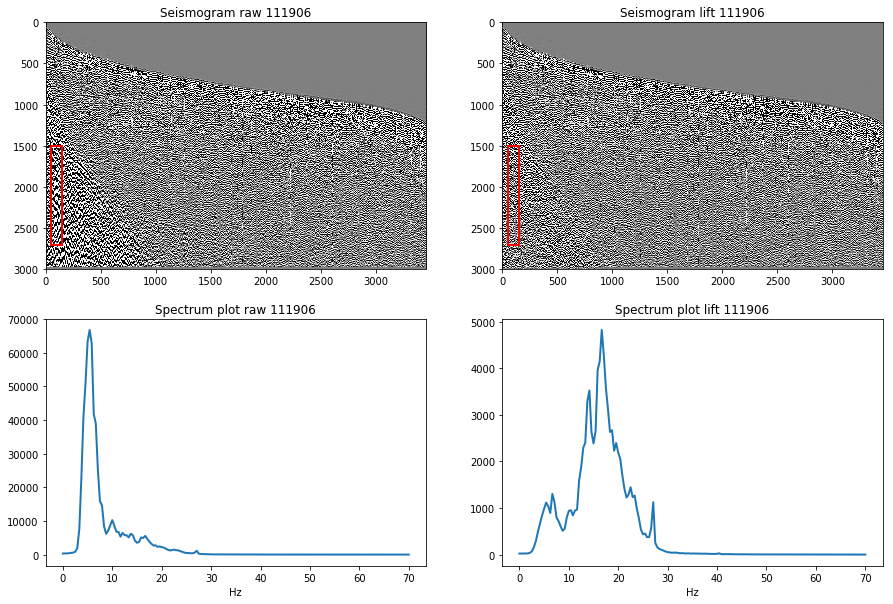

In [6]:
cv = 0.1
batch.spectrum_plot(('raw', 'lift'), batch.indices[0],
                    frame=(slice(50, 150), slice(1500, 2700)),
                    max_freq=70, figsize=(15, 10), vmin=-cv, vmax=cv, cmap='gray')

Same seismogram and power spectrum of a region without ground-rolls:

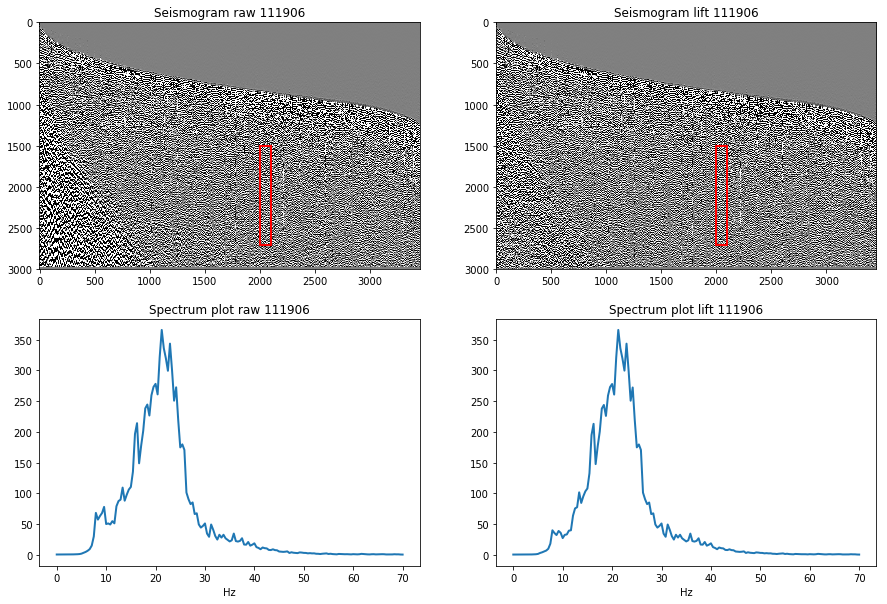

In [7]:
batch.spectrum_plot(('raw', 'lift'), batch.indices[0],
                    frame=(slice(2000, 2100), slice(1500, 2700)), max_freq=70,
                    figsize=(15, 10), vmin=-cv, vmax=cv, cmap='gray')

# Model architecture

The model consists of 2 UNet-like branches. One is for attention mask, the second one is for trace filtering. Model output is a trace that is concatenated from input trace and filtered trace according to attention mask.

Model initialization:

In [8]:
model = UNetAttention('../notebooks/demo_attention_model_S.ckpt')

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
INFO:tensorflow:Restoring parameters from ../notebooks/demo_attention_model_S.ckpt


# Training

Define a template pipeline that will be utilized both for model training and testing:

In [9]:
template_pipeline = (Pipeline()
                     .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000)))

Set a train pipeline:

In [10]:
train_pipeline = train_set >> template_pipeline

Run model training:

In [11]:
for _ in tqdm(range(40)):
    batch = train_pipeline.next_batch(batch_size=64, drop_last=True, n_enochs=None, shuffle=42)
    res = model.train_on_batch(**make_data_train(batch))

100%|██████████| 40/40 [00:15<00:00,  2.55it/s]


# Inference

We consider a sample seismogram for model evaluation.

Select traces from the seismogram (e.g. FFID=111920) and run model inference on the test dataset:

In [12]:
ffid = 111920
test_set = Dataset(TraceIndex(field_index.create_subset([ffid])), SeismicBatch)
test_pipeline = test_set >> template_pipeline

res = []
raw = []
lift = []

batch_size = 1000
for _ in tqdm(range(1 + len(test_set) // batch_size)):
    batch = test_pipeline.next_batch(batch_size, n_epochs=1)
    predicts = model.predict_on_batch(**make_data_predict(batch))
    raw.append(np.vstack(batch.raw))
    lift.append(np.vstack(batch.lift))
    res.append(predicts)

raw = np.vstack(raw)
lift = np.vstack(lift)
predict = np.squeeze(np.vstack([i[0] for i in res]))
attention = np.squeeze(np.vstack([i[1] for i in res]))

100%|██████████| 4/4 [00:08<00:00,  2.13s/it]


Plot raw seismogram, attention mask, model output and difference:

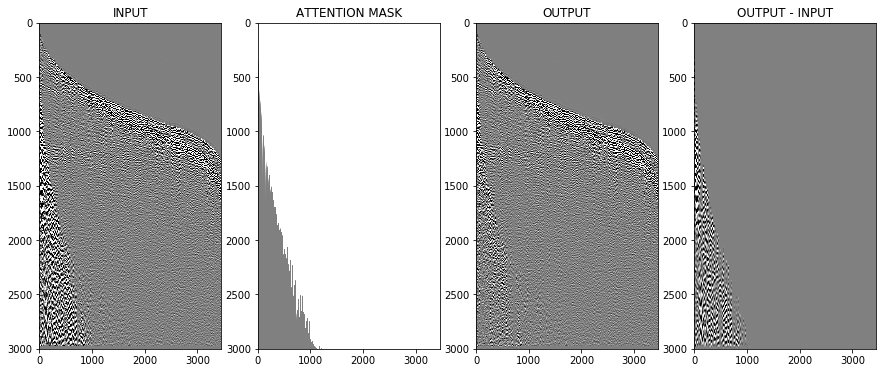




Spectrum comparison in the ground-roll area


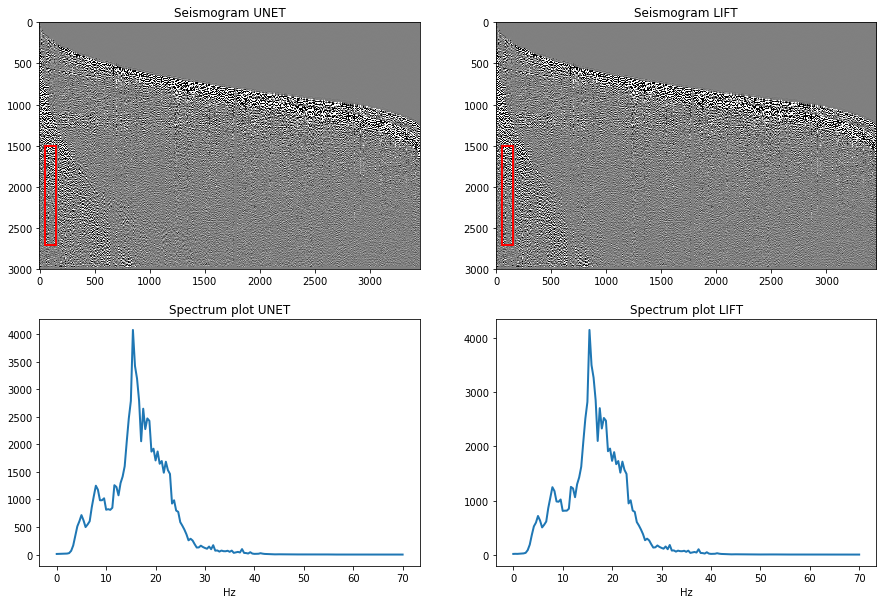




Spectrum comparison out of the ground-roll area


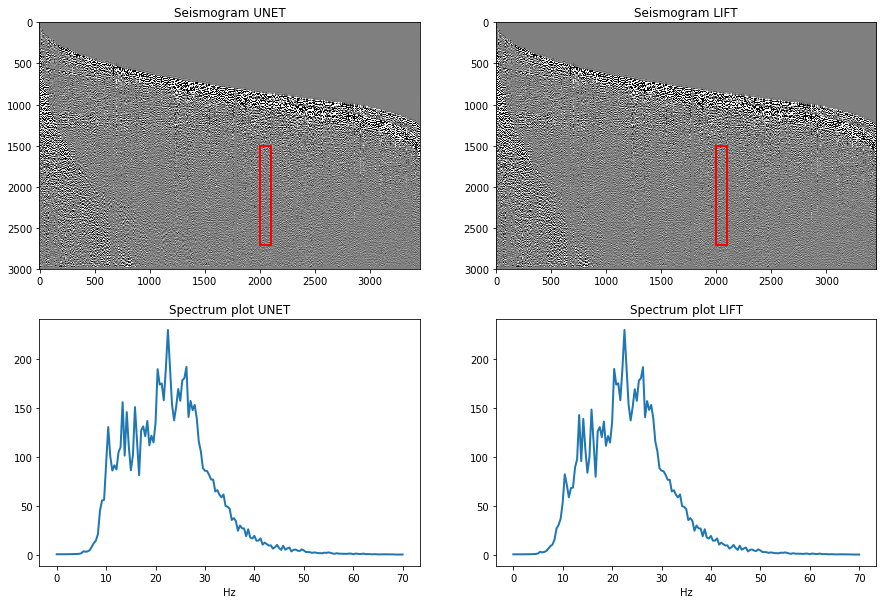

In [13]:
cv = 0.5
seismic_plot([raw, attention, predict, predict - raw],
             names=['INPUT', 'ATTENTION MASK', 'OUTPUT', 'OUTPUT - INPUT'],
             figsize=(15, 6), vmin=-cv, vmax=cv, cmap='gray')


print("\n\n")
print("Spectrum comparison in the ground-roll area")
spectrum_plot([predict, lift], names=['UNET', 'LIFT'],
              frame=(slice(50, 150), slice(1500, 2700)), rate=0.002,
              max_freq=70, figsize=(15, 10), vmin=-cv, vmax=cv, cmap='gray')

print("\n\n")
print("Spectrum comparison out of the ground-roll area")
spectrum_plot([predict, lift], names=['UNET', 'LIFT'],
              frame=(slice(2000, 2100), slice(1500, 2700)), rate=0.002,
              max_freq=70, figsize=(15, 10), vmin=-cv, vmax=cv, cmap='gray')

## Conclusion

Attention model provides a reasonable estimation of ground-roll area and attenuates ground-roll noise close to target seismograms.